In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing import TypedDict, Literal, Annotated, List
from operator import add
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]

@tool
def get_current_club(player_name: str):
    """Gets current club of a player"""
    fake_db = {
        "Lionel Messi": "Paris Saint-Germain",
        "Cristiano Ronaldo": "Al Nassr FC",
    }
    return fake_db.get(player_name, "Current club information not available.")

tools2 = [get_current_club]
model2 = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools2)

def call_model_current_club(state: OverallState):
    local_messages = state.get('messages', [])
    if not local_messages:
        human_message = HumanMessage(content=state['article'])
        local_messages.append(human_message)
    system_message = SystemMessage(content="""You are an agent tasked with determining the current club of a player.
If the current club is mentioned, return it. Otherwise, return 'Current club information not available.'""")
    response = model2.invoke([system_message] + local_messages)
    state['agent_output'] = response.content
    state['messages'] = local_messages + [response]
    return state

def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state['messages'][-1]
    if getattr(last_message, 'tool_calls', None):
        return "tools"
    return END

current_club_graph = StateGraph(OverallState, input=InputState, output=OutputState)
current_club_graph.add_node("call_model_current_club", call_model_current_club)
current_club_graph.add_node("tools", ToolNode(tools2))
current_club_graph.add_edge(START, "call_model_current_club")
current_club_graph.add_conditional_edges("call_model_current_club", should_continue)
current_club_graph.add_edge("tools", "call_model_current_club")

current_club_researcher_agent = current_club_graph.compile()


In [3]:
initial_state = {
    "article": "Lionel Messi will join Real Madrid 2025",
}
current_club_researcher_agent.invoke(initial_state)

{'agent_output': "Lionel Messi's current club is Paris Saint-Germain."}

In [4]:
class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    messages: Annotated[List[BaseMessage], add]

@tool
def get_market_value(player_name: str):
    """Gets current market value of a player"""
    fake_market_value_db = {
        "Lionel Messi": "€50 million",
        "Cristiano Ronaldo": "€30 million",
    }
    return fake_market_value_db.get(player_name, "Market value information not available.")

tools2 = [get_market_value]
model2 = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools2)

def call_model_market_value(state: OverallState):
    local_messages = state.get('messages', [])
    if not local_messages:
        human_message = HumanMessage(content=state['article'])
        local_messages.append(human_message)
    system_message = SystemMessage(content="""You are an agent tasked with determining the market value of a player.
If the market value is mentioned, return it. Otherwise, return 'Market value information not available.'""")
    response = model2.invoke([system_message] + local_messages)
    state['agent_output'] = response.content
    state['messages'] = local_messages + [response]
    return state

def should_continue(state: OverallState) -> Literal["tools", END]:
    last_message = state['messages'][-1]
    if getattr(last_message, 'tool_calls', None):
        return "tools"
    return END

market_value_graph = StateGraph(OverallState, input=InputState, output=OutputState)
market_value_graph.add_node("call_model_market_value", call_model_market_value)
market_value_graph.add_node("tools", ToolNode(tools2))
market_value_graph.add_edge(START, "call_model_market_value")
market_value_graph.add_conditional_edges("call_model_market_value", should_continue)
market_value_graph.add_edge("tools", "call_model_market_value")

market_value_researcher_agent = market_value_graph.compile()

In [5]:
market_value_researcher_agent.invoke({"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"})

{'agent_output': 'The market value of Lionel Messi is €50 million.'}

In [6]:
class InputState(TypedDict):
    article: str

class OutputState(TypedDict):
    agent_output: str

class OverallState(InputState, OutputState):
    pass

model_text_writer = ChatOpenAI(model="gpt-4o-mini")

def expand_text_to_100_words(state: OverallState):
    human_message = HumanMessage(content=state['article'])
    system_message = SystemMessage(content="Expand the following text to be at least 100 words. Maintain the original meaning while adding detail.")
    response = model_text_writer.invoke([system_message, human_message])
    state['agent_output'] = response.content
    return state

text_writer_graph = StateGraph(OverallState, input=InputState, output=OutputState)
text_writer_graph.add_node("expand_text_to_100_words", expand_text_to_100_words)
text_writer_graph.add_edge(START, "expand_text_to_100_words")
text_writer_graph.add_edge("expand_text_to_100_words", END)

text_writer_agent = text_writer_graph.compile()

In [7]:
text_writer_agent.invoke({"article": "Lionel Messi will switch from FC Barcelona to Real Madrid in 2025"})

{'agent_output': "Lionel Messi, the iconic Argentine footballer widely regarded as one of the greatest players of all time, is set to make a highly anticipated transition from FC Barcelona to Real Madrid in the year 2025. This move marks a significant shift in the football landscape, as Messi has spent the majority of his illustrious career at Barcelona, where he has broken numerous records and won countless trophies, including multiple UEFA Champions League titles and Ballon d'Or awards. The prospect of Messi donning the famous white jersey of Real Madrid, the fierce rivals of Barcelona, has sparked intense discussions and speculation among fans and pundits alike. This transfer, if it materializes, will undoubtedly send shockwaves through the footballing world, as it not only signifies a personal change for Messi but also impacts the dynamics of La Liga and European football as a whole. The anticipation surrounding this potential transfer is palpable as fans eagerly await the developm

### Supervisor Agent

In [8]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

class ArticlePostabilityGrader(BaseModel):
    """Binary scores for verifying if an article mentions market value, current club, and meets the minimum word count of 100 words."""

    mentions_market_value: str = Field(
        description="The article mentions the player's market value, 'yes' or 'no'"
    )
    mentions_current_club: str = Field(
        description="The article mentions the player's current club, 'yes' or 'no'"
    )
    meets_100_words: str = Field(
        description="The article has at least 100 words, 'yes' or 'no'"
    )

llm_postability = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_postability_grader = llm_postability.with_structured_output(
    ArticlePostabilityGrader
)

postability_system = """
You are a grader assessing whether a news article meets the following criteria:
1. The article explicitly mentions the player's market value, for example, by stating "market value" or a specific currency amount (e.g., "$50 million"). If this is present, respond with 'yes' for mentions_market_value; otherwise, respond 'no'.
2. The article mentions the player's current club or indicates that the current club information is unavailable (e.g., "Current club information not available"). If this is present, respond with 'yes' for mentions_current_club; otherwise, respond 'no'.
3. The article contains at least 100 words. If this is met, respond with 'yes' for meets_100_words; otherwise, respond 'no'.

Provide three binary scores ('yes' or 'no') as follows:
- mentions_market_value: 'yes' or 'no' depending on whether the article mentions the player's market value.
- mentions_current_club: 'yes' or 'no' depending on whether the article mentions the player's current club or states that the information is unavailable.
- meets_100_words: 'yes' or 'no' depending on whether the article has at least 100 words.
"""

postability_grade_prompt = ChatPromptTemplate.from_messages(
    [("system", postability_system), ("human", "News Article:\n\n{article}")]
)

news_chef = postability_grade_prompt | structured_llm_postability_grader


In [9]:
news_chef.invoke({"article": "Lionel Messi will switch to Real Madrid in 2025"})

ArticlePostabilityGrader(mentions_market_value='no', mentions_current_club='no', meets_100_words='no')

### Workflow

In [10]:
from langchain_core.messages import BaseMessage, HumanMessage
from typing import TypedDict, Literal
from langgraph.graph import END, StateGraph

class InputArticleState(TypedDict):
    article: str

class OutputFinalArticleState(TypedDict):
    final_article: str

class SharedArticleState(InputArticleState, OutputFinalArticleState):
    mentions_market_value: str
    mentions_current_club: str
    meets_100_words: str

def update_article_state(state: SharedArticleState) -> SharedArticleState:
    response = news_chef.invoke({"article": state["article"]})
    state["mentions_market_value"] = response.mentions_market_value
    state["mentions_current_club"] = response.mentions_current_club
    state["meets_100_words"] = response.meets_100_words
    print("State after update_article_state:", state)
    return state

def market_value_researcher_node(state: SharedArticleState) -> SharedArticleState:
    response = market_value_researcher_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    return state

def current_club_researcher_node(state: SharedArticleState) -> SharedArticleState:
    response = current_club_researcher_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    return state

def word_count_rewriter_node(state: SharedArticleState) -> SharedArticleState:
    response = text_writer_agent.invoke({"article": state["article"]})
    state["article"] += f" {response['agent_output']}"
    state["final_article"] = response["agent_output"]
    return state

def news_chef_decider(state: SharedArticleState) -> Literal["market_value_researcher", "current_club_researcher", "word_count_rewriter", END]:
    if state["mentions_market_value"] == "no":
        return "market_value_researcher"
    elif state["mentions_current_club"] == "no":
        return "current_club_researcher"
    elif state["meets_100_words"] == "no" and state["mentions_market_value"] == "yes" and state["mentions_current_club"] == "yes":
        return "word_count_rewriter"
    else:
        return END

workflow = StateGraph(SharedArticleState, input=InputArticleState, output=OutputFinalArticleState)

workflow.add_node("news_chef", update_article_state)
workflow.add_node("market_value_researcher", market_value_researcher_node)
workflow.add_node("current_club_researcher", current_club_researcher_node)
workflow.add_node("word_count_rewriter", word_count_rewriter_node)

workflow.set_entry_point("news_chef")

workflow.add_conditional_edges(
    "news_chef",
    news_chef_decider,
    {
        "market_value_researcher": "market_value_researcher",
        "current_club_researcher": "current_club_researcher",
        "word_count_rewriter": "word_count_rewriter",
        END: END
    },
)

workflow.add_edge("market_value_researcher", "news_chef")
workflow.add_edge("current_club_researcher", "news_chef")
workflow.add_edge("word_count_rewriter", "news_chef")

app = workflow.compile()

In [11]:
app.invoke({"article": "Lionel Messi will to Real Madrid in 2025"})

State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million.', 'mentions_market_value': 'yes', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Current club information not available.', 'mentions_market_value': 'yes', 'mentions_current_club': 'yes', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Current club information not available. Lionel Messi, the legendary Argentine footballer, is expected to make a significant move to Real Madrid in the year 2025. This transfer has sparked con

{'final_article': "Lionel Messi, the legendary Argentine footballer, is expected to make a significant move to Real Madrid in the year 2025. This transfer has sparked considerable excitement among fans and analysts alike, as it would mark a dramatic shift in his illustrious career. Currently, Messi's market value stands at an impressive €50 million, reflecting his enduring talent and influence on the field, despite any potential age-related decline. However, it is important to note that information regarding his current club is not available at this time, which leaves fans curious about his immediate playing situation. As the football world awaits further developments, the prospect of Messi wearing the iconic white jersey of Real Madrid adds an intriguing layer to the ongoing narrative of his career."}

### Add Human in the Loop

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()


class InputState(TypedDict):
    question: str

class IntermediateState(InputState):
    answer: str

class FinalState(IntermediateState):
    api_response: str
    status_code: int

In [ ]:
def input_node(state: InputState) -> InputState:
    return state

def newsagent_node(state: IntermediateState) -> IntermediateState:
    response = app.invoke({"article": state["question"]})
    state["answer"] = response["final_article"]
    return state

def api_call_node(state: FinalState) -> FinalState:
    state["status_code"] = 200
    state["api_response"] = f"API received answer: {state['answer']}"

In [21]:
workflow = StateGraph(FinalState, input=InputState, output=FinalState)

workflow.add_node("newsagent_node", newsagent_node)
workflow.add_node("api_call_node", api_call_node)

workflow.set_entry_point("newsagent_node")

workflow.add_edge("newsagent_node", "api_call_node")
workflow.add_edge("api_call_node", END)

In [22]:
human_app = workflow.compile(checkpointer=checkpointer, interrupt_after=["newsagent_node"])

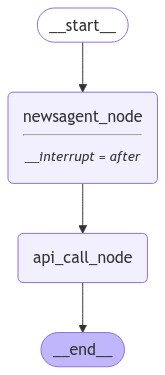

In [23]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        human_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:
config = {"configurable": {"thread_id": "1"}}

In [18]:
human_app.invoke({"question": "Lionel Messi will to Real Madrid in 2025"}, config=config, subgraphs=True)

State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025', 'mentions_market_value': 'no', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million.', 'mentions_market_value': 'yes', 'mentions_current_club': 'no', 'meets_100_words': 'no'}
State after update_article_state: {'article': 'Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Current club information not available.', 'mentions_market_value': 'yes', 'mentions_current_club': 'yes', 'meets_100_words': 'no'}
State after update_article_state: {'article': "Lionel Messi will to Real Madrid in 2025 The market value of Lionel Messi is €50 million. Current club information not available. As of the latest available information, it is anticipated that the renowned footballer Lionel Messi will make a significant move to Real Madrid in the 

((),
 {'question': 'Lionel Messi will to Real Madrid in 2025',
  'answer': "As of the latest available information, it is anticipated that the renowned footballer Lionel Messi will make a significant move to Real Madrid in the year 2025. This transfer has generated considerable buzz and speculation among fans and analysts alike, given Messi's status as one of the greatest players in football history. Currently, Messi's market value is estimated to be around €50 million, reflecting his continued skill and influence on the pitch despite his advancing age. However, details regarding his current club affiliation are not available, leaving fans eager to learn about his next steps. The potential transfer to Real Madrid, a fierce rival of his previous club, Barcelona, would undoubtedly reshape the landscape of European football and ignite passionate discussions among supporters."})

In [19]:
snapshot = human_app.get_state(config)
snapshot.next

('api_call_node',)

In [20]:
human_app.invoke(None, config=config)

{'question': 'Lionel Messi will to Real Madrid in 2025',
 'answer': "As of the latest available information, it is anticipated that the renowned footballer Lionel Messi will make a significant move to Real Madrid in the year 2025. This transfer has generated considerable buzz and speculation among fans and analysts alike, given Messi's status as one of the greatest players in football history. Currently, Messi's market value is estimated to be around €50 million, reflecting his continued skill and influence on the pitch despite his advancing age. However, details regarding his current club affiliation are not available, leaving fans eager to learn about his next steps. The potential transfer to Real Madrid, a fierce rival of his previous club, Barcelona, would undoubtedly reshape the landscape of European football and ignite passionate discussions among supporters.",
 'api_response': "API received answer: As of the latest available information, it is anticipated that the renowned footb

In [24]:
snapshot = human_app.get_state(config)
snapshot.next

()